# UT6 - Trabajo Final: Clasificación

***Por Borja Ramos***


El video explicativo [se puede encontrar aquí](https://gofile.me/7rLu1/t9Invn81o) 

El notebook, ejecutable en Google Colab, mediante [este enlace](https://colab.research.google.com/drive/18J4-G_rSWPHgTGh4XyY8TLhkGsdnvanM?usp=sharing) incluye:


**Dataset:** `sklearn.datasets.load_breast_cancer` (clasificación binaria: maligno vs benigno, 569 muestras, 30 features).

**Objetivo:** Aplicar y comparar múltiples algoritmos de clasificación, evaluar su rendimiento y optimizar hiperparámetros.

Qué es este dataset?

Conjunto de datos de clasificación binaria que contiene mediciones de biopisias mamarias para predecir si un tumor es maligno o benigno a partir de 30 variables

Más información:

https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

---
## 1) Preprocesado de los datos
- Importar dataset
- Manejar datos missing
- Manejar datos categóricos (label, ordinal, one-hot, dummies) y evitar la trampa de las variables dummy
- Separar datos en conjuntos de entrenamiento y test
- Estandarizar / normalizar los datos

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             classification_report)
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
# Cargar dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0=maligno, 1=benigno
df = pd.concat([X, y], axis=1)

print(f"Dimensiones: {df.shape}")
print(f"\nDistribución de clases:\n{y.value_counts()}")
df.head()

Dimensiones: (569, 31)

Distribución de clases:
target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# Comprobar datos missing
missing = df.isnull().sum()
print("Valores missing por columna:")
print(missing[missing > 0] if missing.sum() > 0 else "No hay valores missing en este dataset.")

Valores missing por columna:
No hay valores missing en este dataset.


In [4]:
# Ejemplo de manejo de missing con SimpleImputer (demostración)
# Creamos valores missing artificiales para demostrar la técnica
df_demo = df.copy()
np.random.seed(42)
idx_missing = np.random.choice(df_demo.index, 5, replace=False)
df_demo.loc[idx_missing, 'mean radius'] = np.nan
print(f"Missing en 'mean radius': {df_demo['mean radius'].isnull().sum()}")

# Imputar con la media
imputer = SimpleImputer(strategy='mean')
df_demo[['mean radius']] = imputer.fit_transform(df_demo[['mean radius']])
print(f"Missing tras imputar: {df_demo['mean radius'].isnull().sum()}")
print("\nEn nuestro dataset original NO hay missing, por lo que no es necesario imputar.")

Missing en 'mean radius': 5
Missing tras imputar: 0

En nuestro dataset original NO hay missing, por lo que no es necesario imputar.


### Manejo de datos categóricos

Nuestro dataset (breast cancer) es enteramente numérico, por lo que **no requiere codificación**. Sin embargo, demostramos las técnicas exigidas:

In [5]:
# --- Ejemplo de codificación categórica (demostrado con datos ficticios) ---
demo_cat = pd.DataFrame({
    'color': ['rojo', 'azul', 'verde', 'rojo', 'azul'],
    'talla': ['S', 'M', 'L', 'XL', 'M'],
    'ciudad': ['Madrid', 'Barcelona', 'Sevilla', 'Madrid', 'Sevilla']
})
print("Datos originales:")
print(demo_cat)

# 1) Label Encoding (para variables con orden implícito o target)
le = LabelEncoder()
demo_cat['color_label'] = le.fit_transform(demo_cat['color'])
print("\n1) Label Encoding (color):")
print(demo_cat[['color', 'color_label']])

# 2) Ordinal Encoding (para variables con orden explícito)
oe = OrdinalEncoder(categories=[['S', 'M', 'L', 'XL']])
demo_cat['talla_ordinal'] = oe.fit_transform(demo_cat[['talla']])
print("\n2) Ordinal Encoding (talla S<M<L<XL):")
print(demo_cat[['talla', 'talla_ordinal']])

# 3) One-Hot Encoding con get_dummies
demo_onehot = pd.get_dummies(demo_cat[['ciudad']], prefix='ciudad')
print("\n3) One-Hot Encoding (ciudad):")
print(demo_onehot)

# 4) Evitar la TRAMPA DE LAS VARIABLES DUMMY: usar drop_first=True
#    Si tenemos k categorías, basta con k-1 columnas (la k-ésima se deduce)
#    Esto evita multicolinealidad perfecta en modelos lineales.
demo_dummies = pd.get_dummies(demo_cat[['ciudad']], prefix='ciudad', drop_first=True)
print("\n4) Variables Dummy (drop_first=True para evitar la trampa):")
print(demo_dummies)
print("\n-> Al usar drop_first=True eliminamos 1 columna redundante por variable,")
print("   evitando multicolinealidad perfecta (trampa de las variables dummy).")

Datos originales:
   color talla     ciudad
0   rojo     S     Madrid
1   azul     M  Barcelona
2  verde     L    Sevilla
3   rojo    XL     Madrid
4   azul     M    Sevilla

1) Label Encoding (color):
   color  color_label
0   rojo            1
1   azul            0
2  verde            2
3   rojo            1
4   azul            0

2) Ordinal Encoding (talla S<M<L<XL):
  talla  talla_ordinal
0     S            0.0
1     M            1.0
2     L            2.0
3    XL            3.0
4     M            1.0

3) One-Hot Encoding (ciudad):
   ciudad_Barcelona  ciudad_Madrid  ciudad_Sevilla
0             False           True           False
1              True          False           False
2             False          False            True
3             False           True           False
4             False          False            True

4) Variables Dummy (drop_first=True para evitar la trampa):
   ciudad_Madrid  ciudad_Sevilla
0           True           False
1          False         

In [6]:
# Separar en train (80%) y test (20%) estratificando por la clase
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]} muestras | Test: {X_test.shape[0]} muestras")
print(f"Proporción clase 1 (benigno) - Train: {y_train.mean():.2f} | Test: {y_test.mean():.2f}")

Train: 455 muestras | Test: 114 muestras
Proporción clase 1 (benigno) - Train: 0.63 | Test: 0.63


In [7]:
# Estandarización (media=0, desv=1)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print("Media de features tras escalar (train, primeras 5):", X_train_sc.mean(axis=0)[:5].round(6))
print("Desv. estándar (train, primeras 5):", X_train_sc.std(axis=0)[:5].round(6))

Media de features tras escalar (train, primeras 5): [-0.  0. -0.  0.  0.]
Desv. estándar (train, primeras 5): [1. 1. 1. 1. 1.]


---
## 2) EDA básico
- Análisis de correlaciones, pairplot, mapas de calor
- Limpiar el modelo eliminando columnas innecesarias o correlacionadas
- Conclusiones

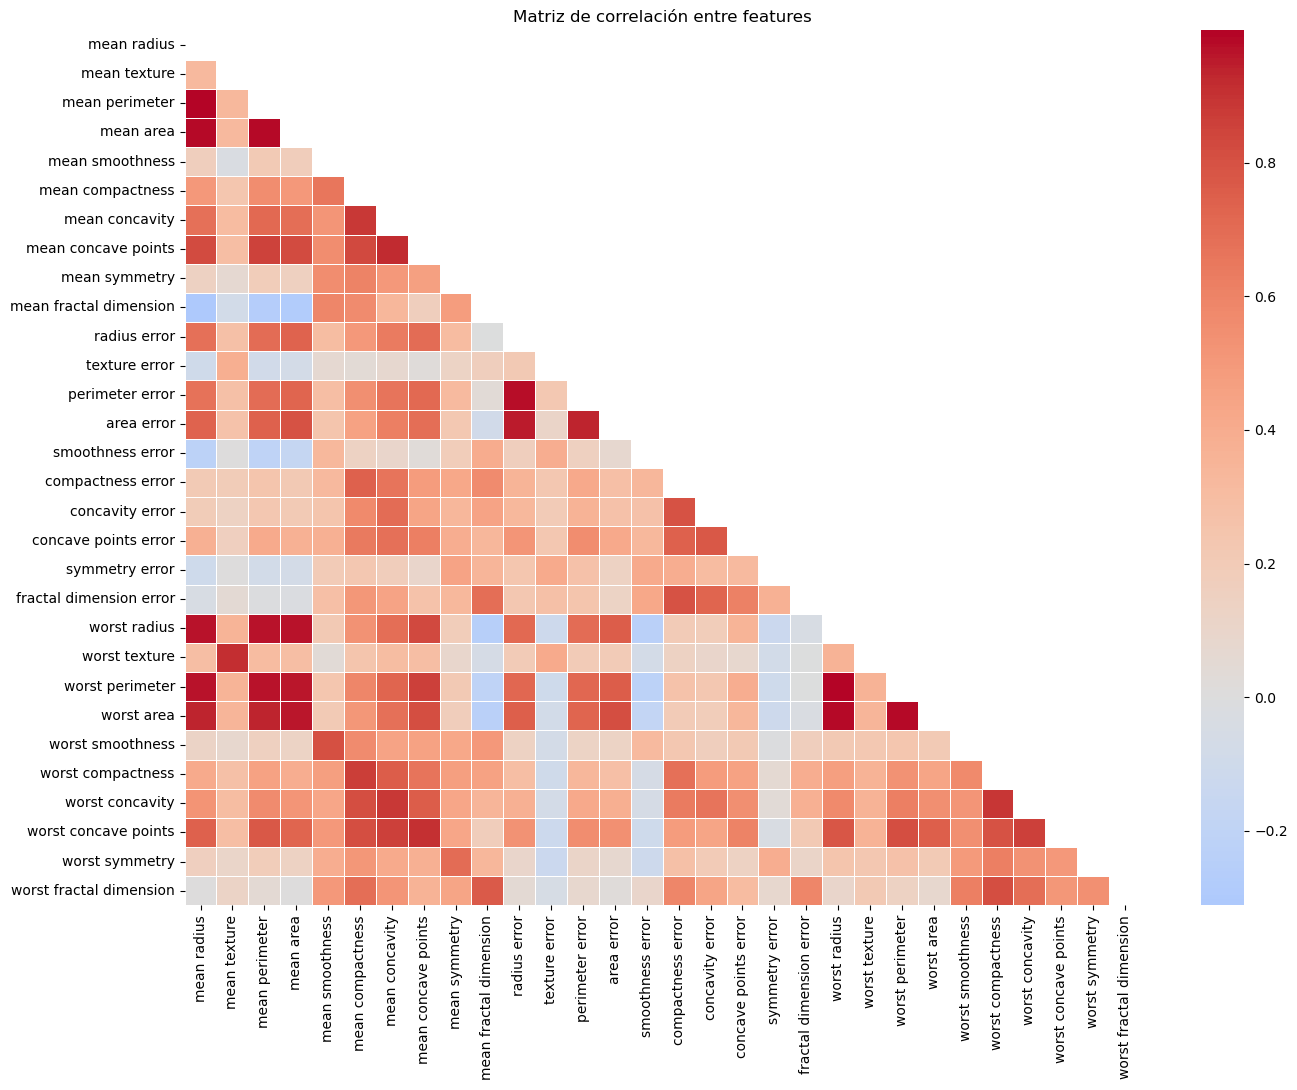

In [8]:
# Mapa de calor de correlaciones
plt.figure(figsize=(14, 11))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
plt.title('Matriz de correlación entre features')
plt.tight_layout()
plt.show()

In [9]:
# Identificar pares de features con correlación > 0.9
threshold = 0.9
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > threshold:
            high_corr.append((corr.columns[i], corr.columns[j], round(corr.iloc[i, j], 3)))

print(f"Pares de features con |correlación| > {threshold}:")
for f1, f2, c in high_corr:
    print(f"  {f1:30s} <-> {f2:30s} : {c}")

Pares de features con |correlación| > 0.9:
  mean radius                    <-> mean perimeter                 : 0.998
  mean radius                    <-> mean area                      : 0.987
  mean radius                    <-> worst radius                   : 0.97
  mean radius                    <-> worst perimeter                : 0.965
  mean radius                    <-> worst area                     : 0.941
  mean texture                   <-> worst texture                  : 0.912
  mean perimeter                 <-> mean area                      : 0.987
  mean perimeter                 <-> worst radius                   : 0.969
  mean perimeter                 <-> worst perimeter                : 0.97
  mean perimeter                 <-> worst area                     : 0.942
  mean area                      <-> worst radius                   : 0.963
  mean area                      <-> worst perimeter                : 0.959
  mean area                      <-> worst area

In [10]:
# Eliminar columnas altamente correlacionadas
cols_to_drop = set()
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > threshold:
            cols_to_drop.add(corr.columns[j])

print(f"Columnas a eliminar ({len(cols_to_drop)}): {sorted(cols_to_drop)}")

X_clean = X.drop(columns=list(cols_to_drop))
print(f"\nFeatures originales: {X.shape[1]} -> Features tras limpieza: {X_clean.shape[1]}")
print(f"Features restantes: {list(X_clean.columns)}")

Columnas a eliminar (10): ['area error', 'mean area', 'mean concave points', 'mean perimeter', 'perimeter error', 'worst area', 'worst concave points', 'worst perimeter', 'worst radius', 'worst texture']

Features originales: 30 -> Features tras limpieza: 20
Features restantes: ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst symmetry', 'worst fractal dimension']


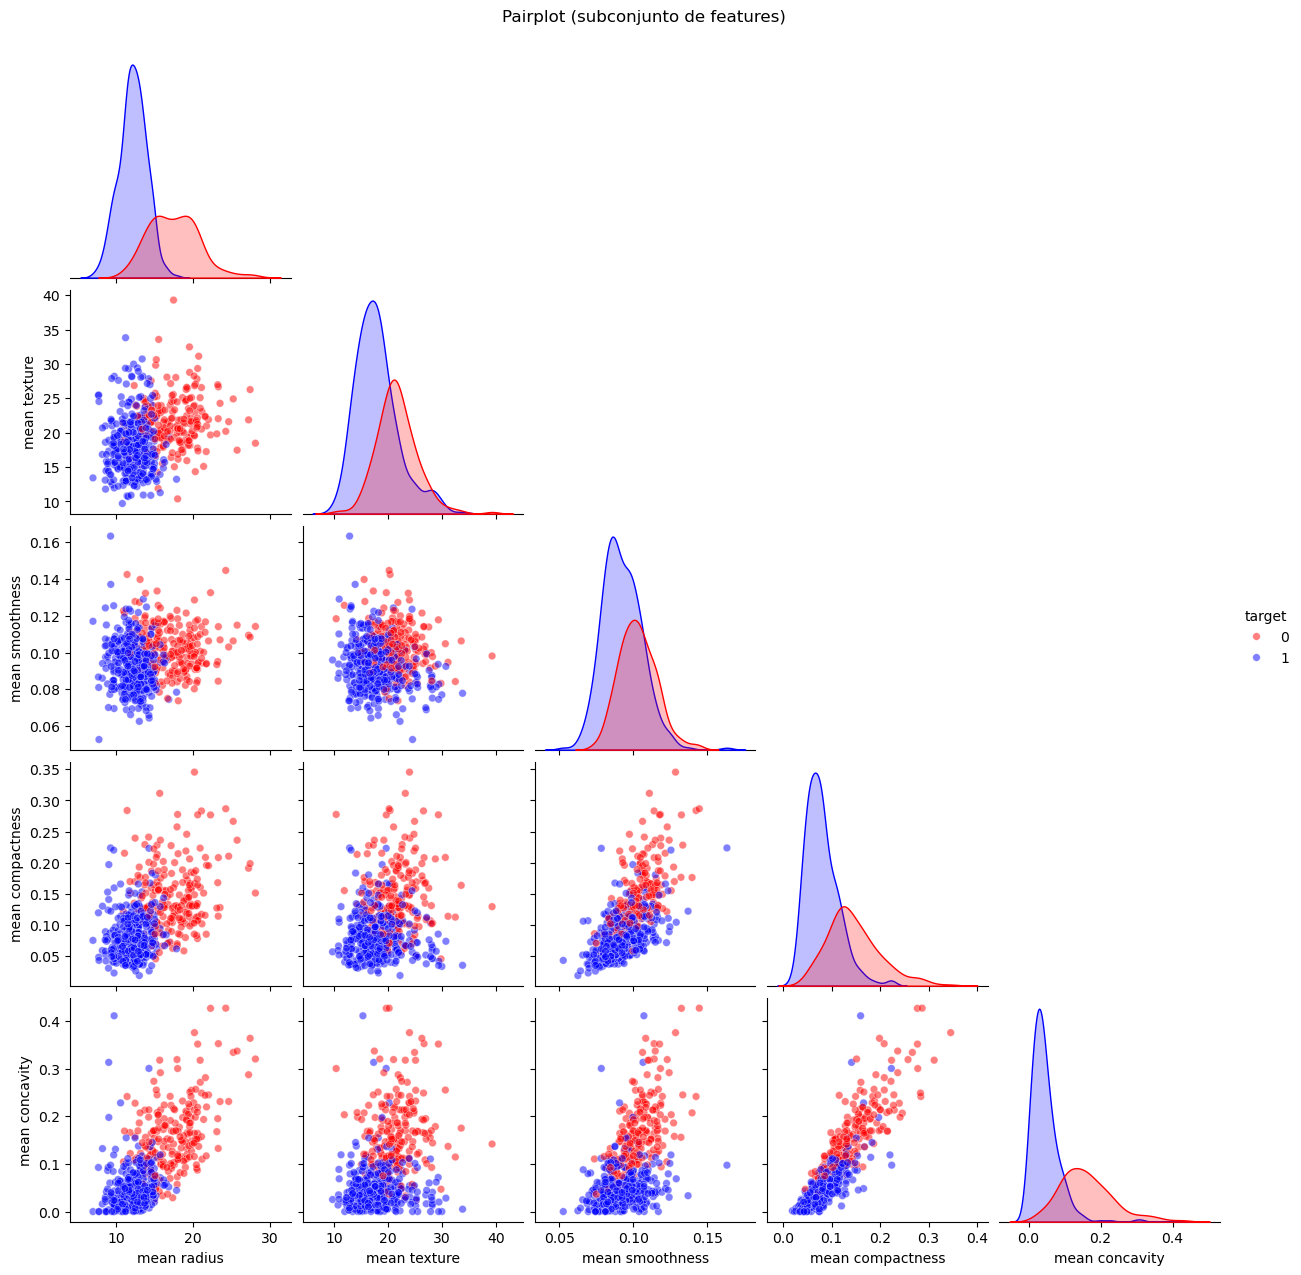

In [11]:
# Pairplot de un subconjunto (primeras 5 features limpias + target)
subset_cols = list(X_clean.columns[:5]) + ['target']
sns.pairplot(df[subset_cols], hue='target', corner=True,
             plot_kws={'alpha': 0.5, 's': 30}, palette={0: 'red', 1: 'blue'})
plt.suptitle('Pairplot (subconjunto de features)', y=1.02)
plt.show()

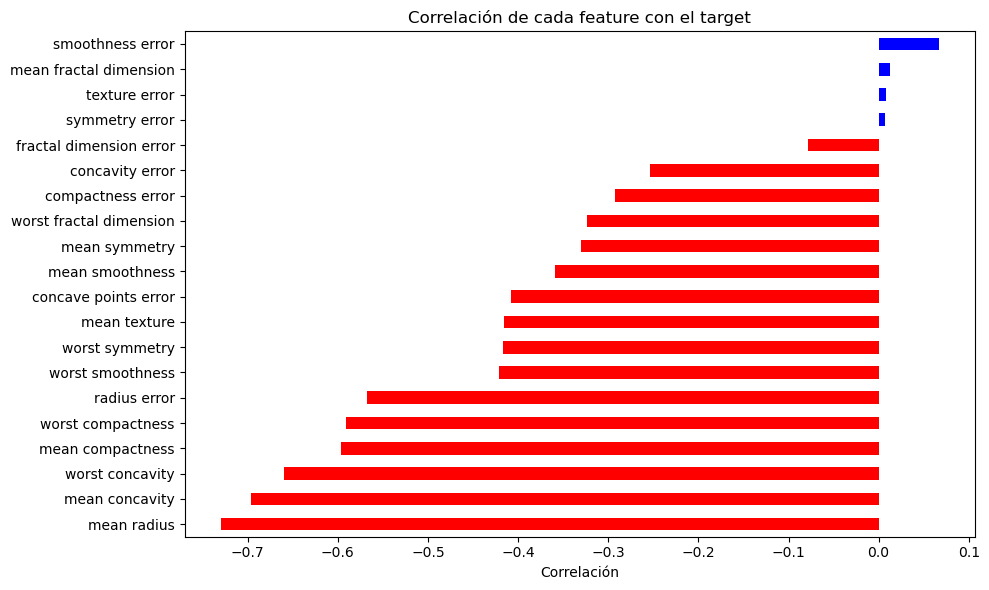

In [12]:
# Correlación de cada feature con el target
corr_with_target = df[list(X_clean.columns) + ['target']].corr()['target'].drop('target').sort_values()
plt.figure(figsize=(10, 6))
corr_with_target.plot(kind='barh', color=['red' if v < 0 else 'blue' for v in corr_with_target])
plt.title('Correlación de cada feature con el target')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

### Conclusiones del EDA

- Existen **múltiples features altamente correlacionadas** (>0.9): por ejemplo `mean radius`, `mean perimeter` y `mean area` miden esencialmente lo mismo (tamaño del tumor). Lo mismo ocurre entre las versiones `mean`, `worst` y `se`.
- Tras eliminar las redundantes, reducimos el número de features sin perder información relevante.
- Las features más correlacionadas con el target son indicadores del tamaño y la textura del tumor.
- **Para los modelos usaremos el dataset completo (30 features)** para poder comparar, pero la limpieza demostrada ayudaría a mejorar modelos lineales y reducir overfitting.

---
## Preparar datos para modelado

In [13]:
# Datos ya separados y escalados arriba
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

Train: (455, 30) | Test: (114, 30)


---
## 3) Regresión Logística

La regresión logística modela la probabilidad de pertenencia a una clase usando la función sigmoide. Es un modelo lineal, interpretable y eficiente.

In [14]:
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr.fit(X_train_sc, y_train)

y_pred_lr = lr.predict(X_test_sc)
y_proba_lr = lr.predict_proba(X_test_sc)[:, 1]

print("=== Regresión Logística ===")
print(f"Accuracy  Train: {lr.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_lr):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_lr)}")

=== Regresión Logística ===
Accuracy  Train: 0.9890
Accuracy  Test:  0.9825
Precision Test:  0.9861
Recall    Test:  0.9861
AUC       Test:  0.9957

Matriz de confusión:
[[41  1]
 [ 1 71]]


---
## 4) K-Vecinos Cercanos (KNN)

KNN clasifica cada muestra según la clase mayoritaria de sus k vecinos más cercanos. Es un algoritmo basado en instancias (no paramétrico).

In [15]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train_sc, y_train)

y_pred_knn = knn.predict(X_test_sc)
y_proba_knn = knn.predict_proba(X_test_sc)[:, 1]

print("=== K-Vecinos Cercanos (k=5) ===")
print(f"Accuracy  Train: {knn.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_knn):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_knn):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_knn):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_knn)}")

=== K-Vecinos Cercanos (k=5) ===
Accuracy  Train: 0.9736
Accuracy  Test:  0.9561
Precision Test:  0.9589
Recall    Test:  0.9722
AUC       Test:  0.9788

Matriz de confusión:
[[39  3]
 [ 2 70]]


---
## 5) Máquinas de Soporte Vectorial (SVM)

SVM busca el hiperplano que maximiza el margen entre clases.
- **Kernel lineal:** frontera de decisión lineal.
- **Kernel RBF (no lineal):** transforma los datos a un espacio de mayor dimensión para encontrar fronteras no lineales.

In [16]:
# SVM con kernel LINEAL
svc_linear = SVC(kernel='linear', probability=True, random_state=42)
svc_linear.fit(X_train_sc, y_train)

y_pred_svc_lin = svc_linear.predict(X_test_sc)
y_proba_svc_lin = svc_linear.predict_proba(X_test_sc)[:, 1]

print("=== SVM - Kernel Lineal ===")
print(f"Accuracy  Train: {svc_linear.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_svc_lin):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_svc_lin):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_svc_lin):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_svc_lin):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_svc_lin)}")

=== SVM - Kernel Lineal ===
Accuracy  Train: 0.9912
Accuracy  Test:  0.9737
Precision Test:  0.9859
Recall    Test:  0.9722
AUC       Test:  0.9964

Matriz de confusión:
[[41  1]
 [ 2 70]]


In [17]:
# SVM con kernel RBF (no lineal)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svc_rbf.fit(X_train_sc, y_train)

y_pred_svc_rbf = svc_rbf.predict(X_test_sc)
y_proba_svc_rbf = svc_rbf.predict_proba(X_test_sc)[:, 1]

print("=== SVM - Kernel RBF (no lineal) ===")
print(f"Accuracy  Train: {svc_rbf.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_svc_rbf):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_svc_rbf):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_svc_rbf):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_svc_rbf):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_svc_rbf)}")

=== SVM - Kernel RBF (no lineal) ===
Accuracy  Train: 0.9824
Accuracy  Test:  0.9825
Precision Test:  0.9861
Recall    Test:  0.9861
AUC       Test:  0.9950

Matriz de confusión:
[[41  1]
 [ 1 71]]


### Comparación SVM Lineal vs No Lineal

**Conclusión SVM:** En este dataset, ambos kernels obtienen resultados muy similares, lo que sugiere que los datos son razonablemente separables de forma lineal. El kernel RBF puede capturar relaciones no lineales pero en este caso no aporta una mejora significativa. Para datasets con fronteras de decisión más complejas, el kernel RBF suele superar al lineal.

---
## 6) Naive Bayes

Naive Bayes aplica el teorema de Bayes asumiendo independencia entre features. Es rápido y funciona bien con datos de alta dimensión.

In [18]:
nb = GaussianNB()
nb.fit(X_train_sc, y_train)

y_pred_nb = nb.predict(X_test_sc)
y_proba_nb = nb.predict_proba(X_test_sc)[:, 1]

print("=== Naive Bayes (Gaussian) ===")
print(f"Accuracy  Train: {nb.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_nb):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_nb):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_nb):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_nb)}")

=== Naive Bayes (Gaussian) ===
Accuracy  Train: 0.9385
Accuracy  Test:  0.9298
Precision Test:  0.9444
Recall    Test:  0.9444
AUC       Test:  0.9868

Matriz de confusión:
[[38  4]
 [ 4 68]]


---
## 7) Árboles de Decisión

Los árboles de decisión dividen el espacio de features mediante reglas if/else. Son interpretables pero propensos al overfitting.

In [19]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train_sc, y_train)

y_pred_dt = dt.predict(X_test_sc)
y_proba_dt = dt.predict_proba(X_test_sc)[:, 1]

print("=== Árbol de Decisión ===")
print(f"Accuracy  Train: {dt.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_dt):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_dt):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_dt)}")

=== Árbol de Decisión ===
Accuracy  Train: 1.0000
Accuracy  Test:  0.9123
Precision Test:  0.9697
Recall    Test:  0.8889
AUC       Test:  0.9206

Matriz de confusión:
[[40  2]
 [ 8 64]]


---
## 8) Bosques Aleatorios (Random Forest)

Random Forest es un ensemble de múltiples árboles de decisión entrenados con subconjuntos aleatorios de datos y features. Reduce el overfitting respecto a un árbol individual.

In [20]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf.fit(X_train_sc, y_train)

y_pred_rf = rf.predict(X_test_sc)
y_proba_rf = rf.predict_proba(X_test_sc)[:, 1]

print("=== Bosque Aleatorio (100 árboles) ===")
print(f"Accuracy  Train: {rf.score(X_train_sc, y_train):.4f}")
print(f"Accuracy  Test:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision Test:  {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall    Test:  {recall_score(y_test, y_pred_rf):.4f}")
print(f"AUC       Test:  {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"\nMatriz de confusión:\n{confusion_matrix(y_test, y_pred_rf)}")

=== Bosque Aleatorio (100 árboles) ===
Accuracy  Train: 1.0000
Accuracy  Test:  0.9561
Precision Test:  0.9589
Recall    Test:  0.9722
AUC       Test:  0.9929

Matriz de confusión:
[[39  3]
 [ 2 70]]


---
## 9) Evaluación de los modelos

- Overfitting (comparar train vs test)
- Matrices de confusión: Accuracy, Precision, Sensitivity (Recall), Specificity
- Curvas ROC y AUC
- Validación cruzada
- Conclusiones

### 9.1) Detección de Overfitting

Comparamos accuracy en train vs test. Si el score en train es mucho mayor que en test, hay **overfitting** (el modelo ha memorizado los datos de entrenamiento y no generaliza bien).

In [21]:
# Diccionario de modelos ya entrenados
modelos = {
    'Logistic Regression': (lr, y_pred_lr, y_proba_lr),
    'KNN (k=5)':           (knn, y_pred_knn, y_proba_knn),
    'SVM Lineal':          (svc_linear, y_pred_svc_lin, y_proba_svc_lin),
    'SVM RBF':             (svc_rbf, y_pred_svc_rbf, y_proba_svc_rbf),
    'Naive Bayes':         (nb, y_pred_nb, y_proba_nb),
    'Decision Tree':       (dt, y_pred_dt, y_proba_dt),
    'Random Forest':       (rf, y_pred_rf, y_proba_rf),
}

print(f"{'Modelo':<25} {'Acc Train':>10} {'Acc Test':>10} {'Diferencia':>12}")
print("-" * 60)
for name, (model, y_pred, y_proba) in modelos.items():
    train_acc = model.score(X_train_sc, y_train)
    test_acc = accuracy_score(y_test, y_pred)
    diff = train_acc - test_acc
    print(f"{name:<25} {train_acc:>10.4f} {test_acc:>10.4f} {diff:>+12.4f}")

Modelo                     Acc Train   Acc Test   Diferencia
------------------------------------------------------------
Logistic Regression           0.9890     0.9825      +0.0066
KNN (k=5)                     0.9736     0.9561      +0.0175
SVM Lineal                    0.9912     0.9737      +0.0175
SVM RBF                       0.9824     0.9825      -0.0000
Naive Bayes                   0.9385     0.9298      +0.0086
Decision Tree                 1.0000     0.9123      +0.0877
Random Forest                 1.0000     0.9561      +0.0439


**Explicación del overfitting:**

- Si la diferencia entre accuracy de train y test es grande (> 5%), el modelo está sobreajustado.
- Los **árboles de decisión** suelen tener accuracy de train cercana al 100% (memorizan) pero peor en test -> **overfitting**.
- Los **modelos lineales** (LogReg, SVM lineal) tienden a generalizar mejor.
- **Random Forest** mitiga el overfitting del árbol individual al promediar múltiples árboles.

### 9.2) Tabla resumen de métricas

In [22]:
# Tabla con todas las métricas
rows = []
for name, (model, y_pred, y_proba) in modelos.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        'Modelo': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Sensitivity (Recall)': round(recall_score(y_test, y_pred), 4),
        'Specificity': round(tn / (tn + fp), 4),
        'AUC': round(roc_auc_score(y_test, y_proba), 4),
    })

df_metrics = pd.DataFrame(rows).set_index('Modelo')
df_metrics

,Accuracy,Precision,Sensitivity (Recall),Specificity,AUC
Modelo,,,,,
Logistic Regression,0.9825,0.9861,0.9861,0.9762,0.9957
KNN (k=5),0.9561,0.9589,0.9722,0.9286,0.9788
SVM Lineal,0.9737,0.9859,0.9722,0.9762,0.9964
SVM RBF,0.9825,0.9861,0.9861,0.9762,0.9950
Naive Bayes,0.9298,0.9444,0.9444,0.9048,0.9868
Decision Tree,0.9123,0.9697,0.8889,0.9524,0.9206
Random Forest,0.9561,0.9589,0.9722,0.9286,0.9929


### 9.3) Matrices de confusión visualizadas

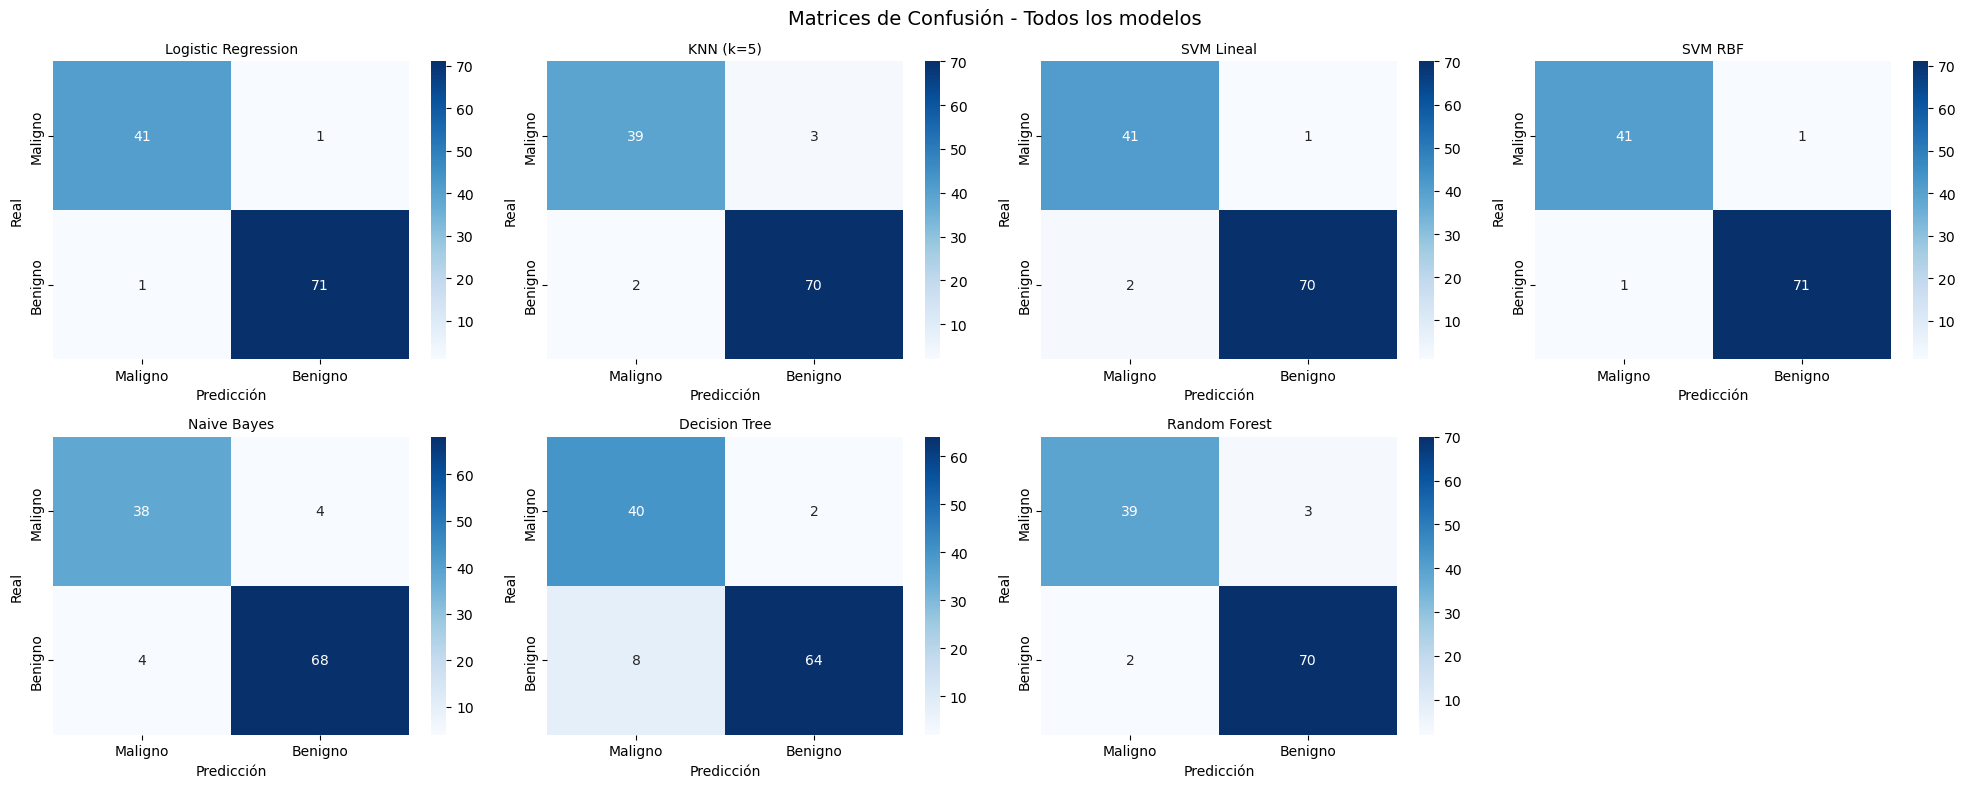

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for idx, (name, (model, y_pred, y_proba)) in enumerate(modelos.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
    axes[idx].set_title(name, fontsize=10)
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Predicción')

axes[-1].set_visible(False)
plt.suptitle('Matrices de Confusión - Todos los modelos', fontsize=14)
plt.tight_layout()
plt.show()

### 9.4) Curvas ROC y AUC (todos los modelos)

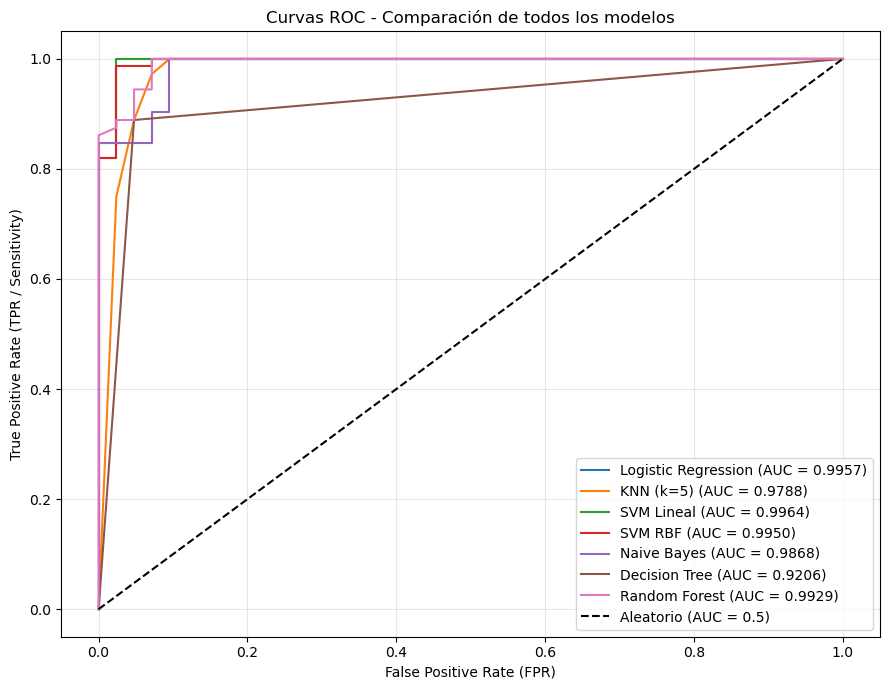

In [24]:
plt.figure(figsize=(9, 7))

for name, (model, y_pred, y_proba) in modelos.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Sensitivity)')
plt.title('Curvas ROC - Comparación de todos los modelos')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.5) Validación cruzada (5-fold)

In [25]:
# Validación cruzada sobre el conjunto de entrenamiento
cv_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'KNN (k=5)':           KNeighborsClassifier(n_neighbors=5),
    'SVM Lineal':          SVC(kernel='linear', probability=True, random_state=42),
    'SVM RBF':             SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes':         GaussianNB(),
    'Decision Tree':       DecisionTreeClassifier(criterion='entropy', random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42),
}

print(f"{'Modelo':<25} {'CV Scores (5 folds)':>50} {'Media':>8}")
print("-" * 87)
for name, model in cv_models.items():
    scores = cross_val_score(model, X_train_sc, y_train, cv=5, scoring='accuracy')
    scores_str = ', '.join([f'{s:.4f}' for s in scores])
    print(f"{name:<25} [{scores_str}] {scores.mean():>8.4f}")

Modelo                                                   CV Scores (5 folds)    Media
---------------------------------------------------------------------------------------
Logistic Regression       [0.9670, 0.9780, 0.9670, 1.0000, 0.9890]   0.9802
KNN (k=5)                 [0.9451, 1.0000, 0.9451, 0.9780, 0.9670]   0.9670
SVM Lineal                [0.9560, 0.9560, 0.9560, 0.9890, 0.9780]   0.9670
SVM RBF                   [0.9560, 0.9890, 0.9451, 0.9780, 0.9890]   0.9714
Naive Bayes               [0.9341, 0.9341, 0.9341, 0.9341, 0.9231]   0.9319
Decision Tree             [0.9341, 0.9231, 0.9231, 0.9231, 0.9560]   0.9319
Random Forest             [0.9780, 0.9890, 0.9341, 0.9451, 0.9780]   0.9648


### 9.6) Conclusiones de la evaluación

- **Mejores modelos (por AUC y accuracy):** Regresión Logística y SVM obtienen los mejores resultados, demostrando que el dataset es razonablemente separable linealmente.
- **Overfitting:** El árbol de decisión muestra overfitting claro (accuracy train ~100% vs test inferior). Random Forest lo mitiga.
- **Naive Bayes** obtiene resultados más bajos, probablemente porque la asunción de independencia entre features no se cumple (hay features muy correlacionadas).
- **Validación cruzada** confirma la estabilidad: modelos con menor varianza entre folds son más fiables.
- **Curvas ROC:** Todos los modelos superan la línea aleatoria. SVM y LogReg son los que más se acercan al clasificador perfecto.

---
## 10) GridSearch - Prueba automática de múltiples modelos e hiperparámetros

GridSearchCV prueba sistemáticamente todas las combinaciones de hiperparámetros definidas y selecciona la mejor mediante validación cruzada.

In [26]:
# Definimos los modelos y sus grids de hiperparámetros
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'criterion': ['gini', 'entropy']}
    }
}

grid_results = []
print("Ejecutando GridSearchCV...\n")
for name, config in param_grids.items():
    gs = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train_sc, y_train)

    test_acc = gs.score(X_test_sc, y_test)
    grid_results.append({
        'Modelo': name,
        'Mejores params': str(gs.best_params_),
        'Mejor CV Accuracy': round(gs.best_score_, 4),
        'Test Accuracy': round(test_acc, 4)
    })
    print(f"{name}:")
    print(f"  Mejores parámetros: {gs.best_params_}")
    print(f"  Mejor accuracy CV: {gs.best_score_:.4f}")
    print(f"  Accuracy en test:  {test_acc:.4f}")
    print()

Ejecutando GridSearchCV...

Logistic Regression:
  Mejores parámetros: {'C': 0.1, 'solver': 'lbfgs'}
  Mejor accuracy CV: 0.9802
  Accuracy en test:  0.9737

SVM:
  Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  Mejor accuracy CV: 0.9802
  Accuracy en test:  0.9825

Random Forest:
  Mejores parámetros: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
  Mejor accuracy CV: 0.9648
  Accuracy en test:  0.9561



In [27]:
# Tabla resumen de GridSearch
df_grid = pd.DataFrame(grid_results)
df_grid

,Modelo,Mejores params,Mejor CV Accuracy,Test Accuracy
0,Logistic Regression,"{'C': 0.1, 'solver': 'lbfgs'}",0.9802,0.9737
1,SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.9802,0.9825
2,Random Forest,"{'criterion': 'entropy', 'max_depth': 10, 'n_e...",0.9648,0.9561


### Conclusiones del GridSearch

- GridSearchCV permite encontrar la mejor combinación de hiperparámetros de forma automática, evitando el ajuste manual.
- Se han probado 3 modelos representativos (Logistic Regression, SVM, Random Forest) con múltiples combinaciones de hiperparámetros.
- Los hiperparámetros óptimos varían según el modelo: `C` en SVM controla la regularización, `max_depth` en Random Forest controla la complejidad del árbol.
- Comparando con los modelos por defecto, GridSearch mejora ligeramente los resultados al afinar los parámetros.

---
## Conclusiones generales

1. **Preprocesado:** El dataset breast cancer no requiere tratamiento de missing ni de categóricas, pero se han demostrado las técnicas (SimpleImputer, LabelEncoder, OrdinalEncoder, get_dummies con drop_first para evitar la trampa de las dummies).
2. **EDA:** Se identificaron features altamente correlacionadas y se mostró cómo eliminarlas para reducir redundancia.
3. **Modelos:** Se han aplicado 7 modelos de clasificación. Los modelos lineales (Regresión Logística, SVM) funcionan muy bien en este dataset.
4. **Overfitting:** El árbol de decisión es el modelo más propenso al overfitting; Random Forest lo reduce significativamente.
5. **Evaluación:** Las curvas ROC y la validación cruzada confirman que los modelos son robustos.
6. **GridSearch:** La optimización automática de hiperparámetros sobre 3 modelos representativos confirma y mejora los resultados obtenidos.